<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels and Kr38m decays simulation analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the 10000 MC Kr38m decay events simulated in a "realistic" fiber barrel to check if we're able to see the krypton signal with enough resolution. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 events. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] average absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


In [3]:
def dark_rate(dark25, dT, T):
    
#     dark25[Kcps] Dark rate at 25ºC
#     dT[ºC] Decay constant at which dark rate halves
#     T[ºC] Temperature

    exponent = (T - 25)/dT

    dark_rate = dark25*(2**exponent)
    
    return dark_rate

In [4]:
def noise(dark_rate, x_talk, t0, tf, dt, n_sensors):
    
#     dark_rate[Kcps] Number of dark pulses per second
#     x_talk[%] Cross talk probability (so the dark pulse is 2pe instead of 1pe)
#     t0[s] Measurements STARTING time
#     tf[s] Measurements ENDIND time
#     dt[s] Width of the time bin

    """
    Here we do it explained with all the steps, it can be done easier tho

    n_bin = (tf - t0)/dt

    pulse_rate = dark_rate*1e3*dt # probability of having a dark pulse in a bin
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal

    n_1pe = int(pulse_rate*pe1*n_bin) # number of 1pe dark counts throughout measurement time in 1 sensor
    n_2pe = int(pulse_rate*pe2*n_bin) # number of 2pe dark counts throughout measurement time in 1 sensor
    
    """;
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal
        
    n_1pe = dark_rate*1e3*(tf - t0)*pe1 # number of 1pe dark counts throughout measurement time in 1 sensor for 1 event
    n_2pe = dark_rate*1e3*(tf - t0)*pe2 # number of 2pe dark counts throughout measurement time in 1 sensor for 1 event
    
    n_1pe = n_1pe*n_sensors # TOTAL number of 1pe dark counts throughout measurement time for all sensors for 1 event
    n_2pe = n_2pe*n_sensors # TOTAL number of 2pe dark counts throughout measurement time for all sensors for 1 event

    n_1pe = int(n_1pe)
    n_2pe = int(n_2pe)
    
    return n_1pe, n_2pe

<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [6]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> dark_rate: </b> Dark pulses rate. </p>
 -  <p style="font-size: 17px; color: black;"> <b> x_talk: </b> Cross talk probability. </p>
 -  <p style="font-size: 17px; color: black;"> <b> n_sensors: </b> Total number of sensors used. </p>
 

In [7]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [8]:
# path = '/home/investigator/mariandbt/python/data/'
# path = path + '/20230921_NEXT100_full_fiber_barrel'

path = '/home/investigator/mariandbt/nexus'

filename = os.path.join(path, "Next100_full.next.h5")
# filename = os.path.join(path, "Next100_full_1event.next.h5")
# filename = os.path.join(path, "Next100_full_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_noEL_100ev_sensName.next.h5")
# filename = os.path.join(path, "Next100_full_noEL_20ev.next.h5")


-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [9]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Next100_full.next.h5 (File) ''
Last modif.: '2023-10-13T11:11:43+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(39,)) ''
/MC/hits (Table(695,)) ''
/MC/particles (Table(41246,)) ''
/MC/sns_positions (Table(12,)) ''
/MC/sns_response (Table(12,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [10]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
# data = pd.read_hdf(filename, "/MC/particles")
# data = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")
# data = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [11]:
dst = data.copy()

In [12]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [13]:
# dst.final_volume.unique() 
# dst.initial_volume.unique()
# dst.particle_name.unique()
dst.sensor_id.unique(), len(dst.sensor_id.unique())

(array([21171, 35007, 33040, 26174, 21173, 56012, 19173, 42062, 17004,
        37021, 54004, 25002], dtype=uint32),
 12)

In [14]:
dst.time_bin.unique(), len(dst.time_bin.unique())
dst.charge.unique(), len(dst.charge.unique())


(array([1], dtype=uint32), 1)

In [15]:
# dst.loc[dst.final_volume.str.contains('SENS')]
# dst.loc[(dst.initial_volume != 'WORLD') & (dst.primary == 0)]
dst

,event_id,sensor_id,time_bin,charge
0,0,21171,58.9,1
1,2,35007,0.0,1
2,2,33040,0.0,1
3,3,26174,51.0,1
4,4,21173,34.9,1
5,4,56012,0.0,1
6,5,19173,345.7,1
7,5,42062,0.0,1
8,6,17004,0.0,1
9,7,37021,0.0,1


-  <p style="font-size: 17px; color: black;"> <b> Tests on the data: </b> We perform some tests on the dataset to check the simulation is valid. </p>

-  <p style="font-size: 17px; color: black;"> Group the data by sensors. </p>

In [16]:
dst.charge.sum(), len(dst.charge)

(12, 12)

In [17]:
# g = dst.groupby(dst.sensor_id)
g = dst.groupby(dst.event_id)


In [18]:
# g.charge.sum()

<h1> __________________________ </h1>
<h2> Analysis </h2>

In [19]:
dst_sens = pd.read_hdf(filename, "/MC/sns_positions")
dst_sens.sensor_name.unique()
len(dst_sens.loc[dst_sens.sensor_name == 'F_SENSOR'])
# dst_sens.loc[dst_sens.sensor_name == 'F_SENSOR']
dst_sens

,sensor_id,sensor_name,x,y,z
0,21171,F_SENSOR,133.095337,465.085785,7.825000
1,35007,SiPM,8.275000,365.924988,-34.099998
2,33040,SiPM,86.025002,8.275000,-34.099998
3,26174,F_SENSOR,-463.419739,150.762405,7.825000
4,21173,F_SENSOR,196.994431,441.828400,7.825000
5,56012,SiPM,397.024994,257.075012,-34.099998
6,19173,F_SENSOR,434.908325,211.834610,7.825000
7,42062,SiPM,241.524994,225.975006,-34.099998
8,17004,SiPM,-240.524994,70.474998,-34.099998
9,37021,SiPM,163.774994,-411.575012,-34.099998


In [20]:
dst_particle = pd.read_hdf(filename, "/MC/particles")

In [21]:
dst_particle[dst_particle.particle_name == 'ie-']

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
22,0,30,ie-,0,2,189.097061,-135.319473,24.419052,0.000058,189.223740,-133.388885,-7.676,31795.511719,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
23,0,29,ie-,0,2,189.097748,-135.319351,24.418892,0.000070,186.743271,-135.565292,-7.676,32027.542969,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
24,0,28,ie-,0,2,189.096695,-135.319534,24.419136,0.000051,189.151398,-136.198639,-7.676,32198.591797,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
25,0,27,ie-,0,2,189.096024,-135.319656,24.419292,0.000039,187.514160,-135.452637,-7.676,31547.636719,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
26,0,26,ie-,0,2,189.098892,-135.319168,24.418627,0.000091,187.605179,-136.768875,-7.676,32582.732422,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
27,0,25,ie-,0,2,189.094284,-135.319946,24.419693,0.000007,191.864990,-132.966507,-7.676,31899.250000,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
28,0,24,ie-,0,2,189.096527,-135.319565,24.419174,0.000048,189.519104,-134.695450,-7.676,31992.279297,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
29,0,23,ie-,0,2,189.098938,-135.319153,24.418617,0.000092,187.198074,-135.044998,-7.676,32056.750000,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
30,0,22,ie-,0,2,189.094879,-135.319839,24.419556,0.000018,187.385864,-138.018814,-7.676,32162.945312,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift
31,0,21,ie-,0,2,189.097076,-135.319473,24.419048,0.000058,189.688599,-134.771851,-7.676,32323.720703,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift


In [22]:
dst_particle = pd.read_hdf(filename, "/MC/particles")
dst_particle.loc[dst_particle.particle_name == 'opticalphoton']
dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') & 
                 (dst_particle.creator_proc == 'Scintillation') 
#                  (dst_particle.final_volume.str.contains('SENSAREA')) 
#                  (dst_particle.final_volume.str.contains('F_SENSOR_SENSAREA')) 
#                  (~dst_particle.final_volume.str.contains('F_SENSOR_CASE_')) 
#                  (dst_particle.event_id < 5) 
                ]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,44,opticalphoton,0,2,189.095108,-135.319809,24.419502,93.639053,188.022232,-88.948723,-28.800127,93.881004,ACTIVE,SIPM_BOARD_MASK_WLS,-1.030877e-07,4.455558e-06,-5.113594e-06,1.536341e-07,3.231811e-06,-5.961817e-06,0.000007,70.595741,Scintillation,OpWLS
4,0,43,opticalphoton,0,2,189.096039,-135.319656,24.419287,166.292313,462.000244,-156.363998,405.590546,168.031128,ACTIVE,Y11_WLS_17158,4.869084e-06,-9.298807e-07,5.794906e-06,3.558937e-06,3.785630e-06,5.581807e-06,0.000008,485.766357,Scintillation,OpWLS
5,0,42,opticalphoton,0,2,189.095779,-135.319687,24.419348,104.943794,71.519997,-67.444397,-0.062327,105.438118,ACTIVE,EL_GRID_GATE,-6.506371e-06,3.756062e-06,-1.354759e-06,-6.506371e-06,3.756062e-06,-1.354759e-06,0.000008,137.950989,Scintillation,OpAbsorption
6,0,41,opticalphoton,0,2,189.094727,-135.319870,24.419592,45.679607,-299.179962,378.493103,744.436829,50.020607,ACTIVE,Y11_WLS_699,-8.332120e-07,7.422264e-06,-2.584497e-06,-2.725083e-06,5.824080e-06,4.595419e-06,0.000008,1137.502075,Scintillation,OpWLS
7,0,40,opticalphoton,0,2,189.094604,-135.319901,24.419622,188.920776,318.524567,-362.095032,456.671997,190.654144,ACTIVE,Y11_WLS_1573,1.756612e-06,-3.077777e-06,5.866508e-06,4.462906e-06,-4.267948e-06,2.973450e-06,0.000007,504.996368,Scintillation,OpWLS
8,0,39,opticalphoton,0,2,189.095810,-135.319687,24.419342,236.546829,220.691925,-148.789307,-28.800837,236.769836,ACTIVE,SIPM_BOARD_MASK_WLS,3.721108e-06,-1.586334e-06,-6.267752e-06,2.284361e-06,-7.934261e-07,-7.056911e-06,0.000007,63.341423,Scintillation,OpWLS
9,0,38,opticalphoton,0,2,189.097809,-135.319351,24.418879,142.287033,113.898018,471.601776,573.297363,145.123260,ACTIVE,Y11_WLS_330,-6.462241e-07,5.215534e-06,4.716749e-06,-6.150813e-07,6.447450e-06,2.814104e-06,0.000007,821.751709,Scintillation,OpWLS
13,0,37,opticalphoton,0,2,189.094803,-135.319855,24.419573,150.015106,470.136627,109.795860,254.036926,151.532501,ACTIVE,Y11_WLS_058,4.602066e-06,4.013785e-06,3.759999e-06,6.891149e-06,1.586142e-06,1.193021e-06,0.000007,437.938904,Scintillation,OpWLS
15,0,36,opticalphoton,0,2,189.095871,-135.319672,24.419327,44.515652,340.404877,-162.830231,-0.021828,45.071739,ACTIVE,EL_GRID_GATE,7.390412e-06,-1.343703e-06,-1.193784e-06,7.390412e-06,-1.343703e-06,-1.193784e-06,0.000008,155.719681,Scintillation,OpAbsorption
16,0,35,opticalphoton,0,2,189.096390,-135.319595,24.419207,84.437141,358.193115,-355.271637,2.753870,85.401230,ACTIVE,GATE_RING,4.355424e-06,-5.665305e-06,-5.580340e-07,4.355424e-06,-5.665305e-06,-5.580340e-07,0.000007,278.284027,Scintillation,Transportation


In [23]:
dst_particle.final_proc.unique()

array(['OpWLS', 'OpAbsorption', 'Transportation', 'Drift', 'NoProcess',
       'StepLimiter', 'phot'], dtype=object)

In [24]:
dst_particle.particle_name.unique()
# dst_particle.final_volume.unique()


array(['opticalphoton', 'ie-', 'e-', 'gamma'], dtype=object)

In [25]:
len(dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') &
                     (dst_particle.final_volume.str.contains('SENSAREA'))])
#                      (dst_particle.final_volume.str.contains('F_SENSOR_SENSAREA'))])
# len(dst_particle.loc[(dst_particle.final_volume.str.contains('F_SENSOR'))])


23

In [26]:
dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') &
                                   (dst_particle.final_proc != 'OpWLS')
                                  ]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
2,0,47,opticalphoton,0,45,-458.906616,-170.800491,660.079346,106.772423,-144.901703,-124.714401,-10.188897,152.985260,Y11,EL_GRID_ANODE,-1.687332e-06,1.553566e-06,7.336464e-07,-1.788072e-06,-9.903243e-07,-1.273165e-06,0.000002,13656.066406,OpWLS,OpAbsorption
3,0,46,opticalphoton,0,45,-458.906616,-170.800491,660.079346,106.772423,95.328682,495.411652,-12.128059,115.718750,Y11,ANODE_RING,-2.073670e-06,8.845346e-07,-1.284012e-06,1.167399e-06,2.307945e-06,2.043656e-07,0.000003,2650.013184,OpWLS,Transportation
5,0,42,opticalphoton,0,2,189.095779,-135.319687,24.419348,104.943794,71.519997,-67.444397,-0.062327,105.438118,ACTIVE,EL_GRID_GATE,-6.506371e-06,3.756062e-06,-1.354759e-06,-6.506371e-06,3.756062e-06,-1.354759e-06,0.000008,137.950989,Scintillation,OpAbsorption
11,0,50,opticalphoton,0,48,-475.317352,-82.236725,1029.899536,157.946075,364.100159,67.044098,-10.188536,170.372650,Y11,EL_GRID_ANODE,2.892270e-07,1.302720e-06,2.064928e-06,-3.495951e-07,-1.927159e-06,1.486102e-06,0.000002,3673.136230,OpWLS,OpAbsorption
15,0,36,opticalphoton,0,2,189.095871,-135.319672,24.419327,44.515652,340.404877,-162.830231,-0.021828,45.071739,ACTIVE,EL_GRID_GATE,7.390412e-06,-1.343703e-06,-1.193784e-06,7.390412e-06,-1.343703e-06,-1.193784e-06,0.000008,155.719681,Scintillation,OpAbsorption
16,0,35,opticalphoton,0,2,189.096390,-135.319595,24.419207,84.437141,358.193115,-355.271637,2.753870,85.401230,ACTIVE,GATE_RING,4.355424e-06,-5.665305e-06,-5.580340e-07,4.355424e-06,-5.665305e-06,-5.580340e-07,0.000007,278.284027,Scintillation,Transportation
18,0,52,opticalphoton,0,34,161.819443,-112.619583,-28.800209,114.961647,-104.567802,262.913177,-10.144235,118.662766,SIPM_BOARD_MASK_WLS,EL_GRID_ANODE,6.931482e-07,-2.026269e-06,-1.176761e-06,-1.937248e-06,-5.654176e-07,-1.377809e-06,0.000002,1101.349365,OpWLS,OpAbsorption
21,0,31,opticalphoton,0,2,189.099869,-135.319000,24.418400,3.085063,168.918884,-18.218246,-0.067453,3.508095,ACTIVE,EL_GRID_GATE,-1.215737e-06,7.054353e-06,-1.475071e-06,-1.215737e-06,7.054353e-06,-1.475071e-06,0.000007,121.323593,Scintillation,OpAbsorption
51,0,91,opticalphoton,0,90,-87.099297,-481.405090,126.669289,93.928795,249.105103,-184.017899,-0.023155,95.500130,Y11_WLS_122,EL_GRID_GATE,6.881803e-08,2.001206e-06,1.695250e-06,1.893295e-06,1.671109e-06,-7.115199e-07,0.000003,467.200195,OpWLS,OpAbsorption
55,0,93,opticalphoton,0,87,266.568787,-117.135788,-28.800415,406.278961,259.522156,-107.484116,-10.121812,406.353546,SIPM_BOARD_MASK_WLS,EL_GRID_ANODE,-2.461539e-07,2.767014e-06,9.831656e-07,-9.361085e-07,1.282419e-06,2.482473e-06,0.000003,22.179070,OpWLS,OpAbsorption


In [27]:
# category_counts = dst_particle.final_volume.value_counts()
category_counts = dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') &
                                   (dst_particle.final_proc != 'OpWLS')
                                  ].final_volume.value_counts()
# category_counts

In [28]:
category_counts[:10]

EL_GRID_ANODE      1648
EL_GRID_GATE       1644
TEFLON_CAP          372
SIPM_BOARD_MASK     356
Y11                 264
ANODE_RING          195
SIPM_BOARD          171
SIPM_S13372         155
TP_COPPER_PLATE     116
LAB                 105
Name: final_volume, dtype: int64

In [29]:
# dst_particle.loc[dst_particle.final_volume == 'EL_GAP']

In [30]:
# category_counts[category_counts > 10]

In [31]:
# dst_particle.loc[dst_particle.initial_volume.str.contains('Y11_WLS')]
# dst_particle.loc[dst_particle.final_volume == 'Y11']


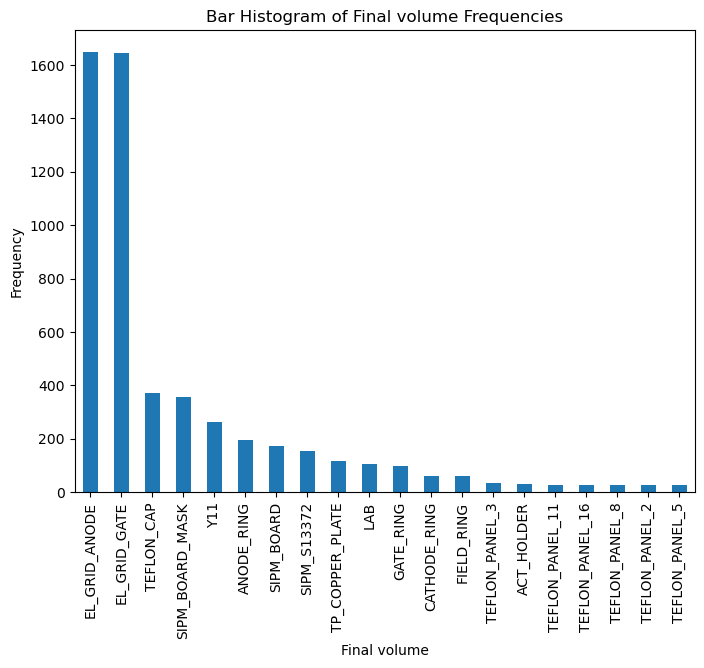

In [32]:
plt.figure(figsize=(8, 6))

# category_counts[category_counts > 100].plot(kind="bar")
category_counts[:20].plot(kind="bar")

plt.xlabel("Final volume")
plt.ylabel("Frequency")
plt.title("Bar Histogram of Final volume Frequencies")
plt.xticks(rotation=90)  # Rotates the x-axis labels if needed
plt.show()


<h2> Charge distribution in an event. </h2>

-  <p style="font-size: 17px; color: black;"> 1 event </p>

In [33]:
ev = 0

In [34]:
wvf = dst.groupby(dst.event_id).get_group(ev)

In [35]:
# wvf.groupby(wvf.sensor_id).get_group(3163)
wvf

,event_id,sensor_id,time_bin,charge
0,0,21171,58.9,1


-  <p style="font-size: 17px; color: black;"> All events </p>

In [36]:
n_events = dst.event_id.max() + 1

In [37]:
# for ev, ev_group in dst.groupby(dst.event_id):
#     for sens, sens_group in ev_group.groupby(ev_group.sensor_id):
        
#         Introduce here a np.hist() for each sensor in each event and obtain the corresponding info
        
        

In [38]:
# len(time_bin), len(np.unique(time_bin))

In [39]:
# time_bin

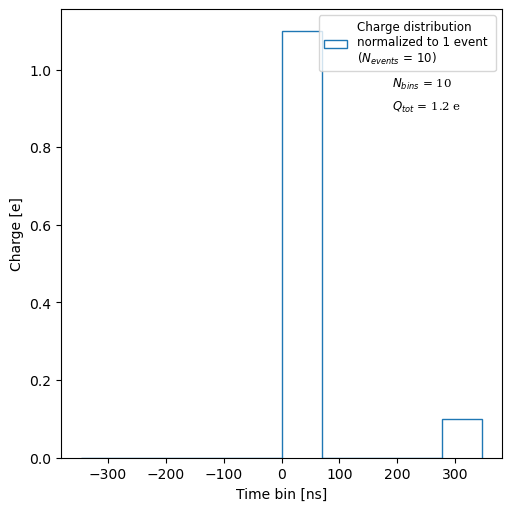

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

n_bins = 10
font_size = 8.5

events, bins, bars = ax.hist(dst.time_bin, n_bins, 
                             weights = dst.charge/n_events,
                             density=False,
                             range=(-1*(dst.time_bin.max()), dst.time_bin.max()),
                             label='Charge distribution \nnormalized to 1 event \n($N_{events}$ = %s)'%(n_events), 
                             histtype='step')

ax.text(0.75, .85, r'$N_{bins}$ = ' + str(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.text(0.75, .8, r'$Q_{tot}$ = ' + str(events.sum()) + ' e', transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size);


In [41]:
events.sum()

1.2

<h2> Add dark counts. </h2>

-  <p style="font-size: 17px; color: black;"> Create the noise at 25ºC </p>

In [42]:
dt = 1e-6 # [s] = 1us
dt = 10*1e-6 # [s] = 1us


In [43]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [44]:
n_1pe, n_2pe = noise(dark25, x_talk, t0, tf, dt, n_sensors)

print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

We have 115 1pe dark pulses and 8 2pe dark pulses


In [45]:
noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

t_noise = np.concatenate((noise_1pe, noise_2pe))
c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

In [46]:
t_signal = np.asarray(dst.time_bin)
c_signal = np.asarray(dst.charge)

In [47]:
tt = np.concatenate((t_signal, t_noise))
cc = np.concatenate((c_signal/n_events, c_noise))

Total events = 132 = 1 (signal) + 131 (bkg) = 132


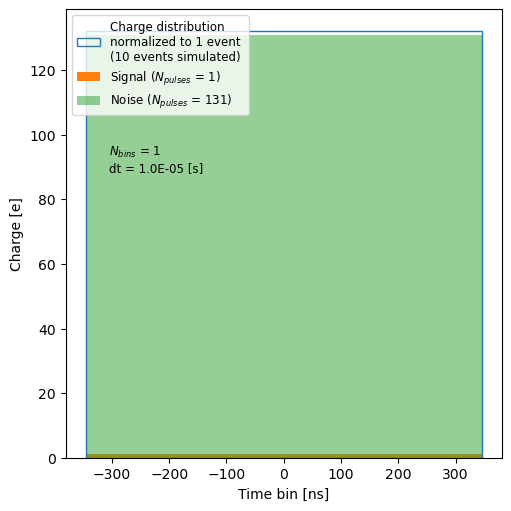

In [48]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

font_size = 8.5


t_low = -1*(tt.max())
t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
n_bins = int((t_up - t_low)*1e-9/dt) + 1

# "Data"
events, bins, bars = ax.hist(tt, n_bins, 
                             weights = cc,  # only part of it has to be normalized (signal part)
                             density=False,
                             range=(t_low, t_up),
                             label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                             histtype='step')


# Signal
s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                   weights = c_signal/n_events,
                                   density=False,
                                   range=(t_low, t_up),
                                   label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                   alpha = 1,
                                   histtype='stepfilled')


# Noise
bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                         weights = c_noise, # noise is already normalized
                                         density=False,
                                         range=(t_low, t_up),
                                         label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                         alpha = 0.5,
                                         histtype='stepfilled')


ax.text(0.1, .7, '$N_{bins}$ = %s \ndt = %.1E [s]'%(n_bins, dt), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size, loc = 'upper left');

print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                         s_events.sum(), bkg_events.sum(), 
                                                         events.sum()))


In [49]:
events.mean()

132.2

Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132


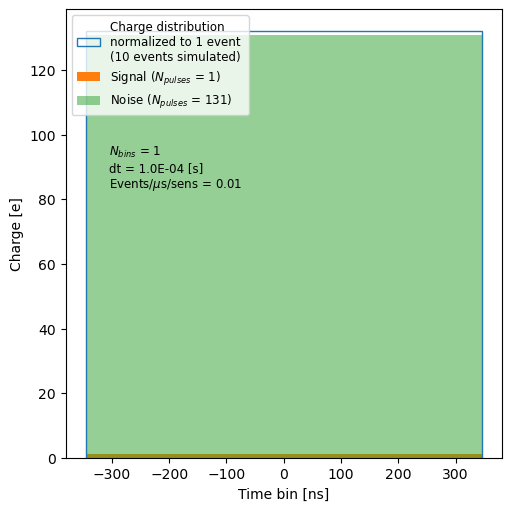

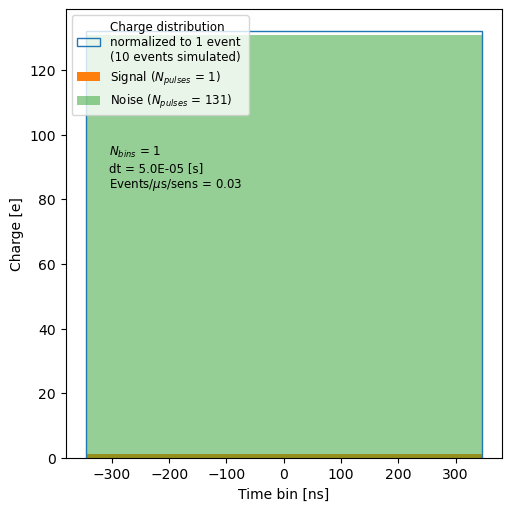

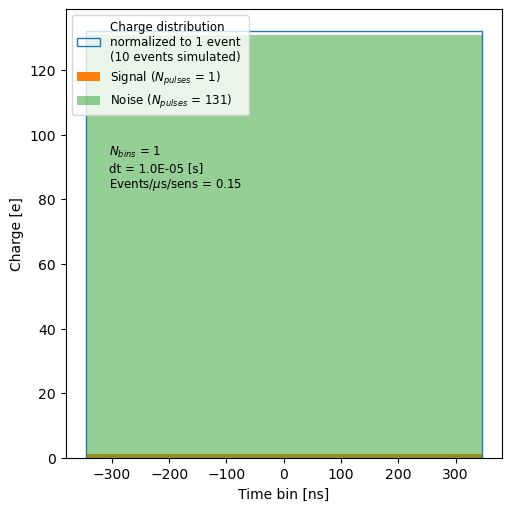

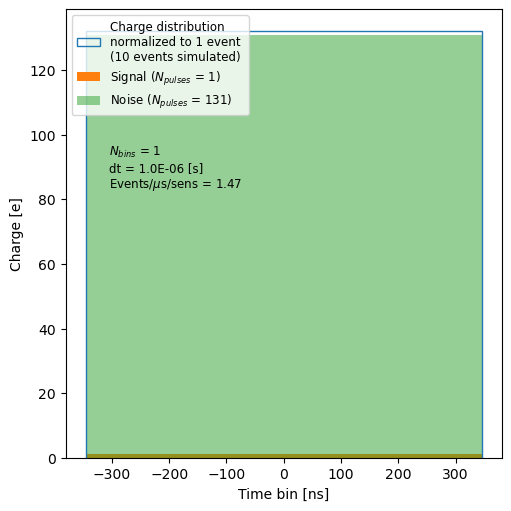

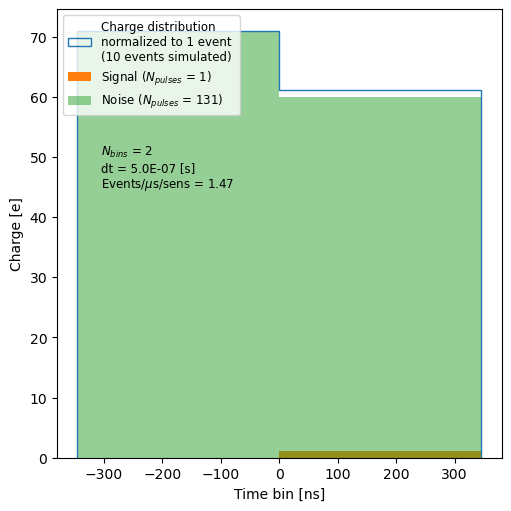

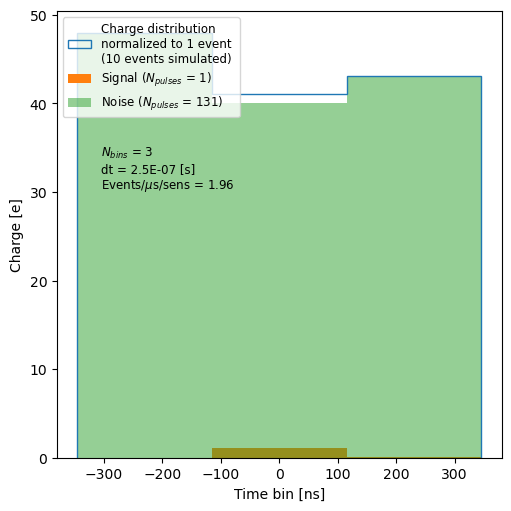

In [50]:
font_size = 8.5

# for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
for dt in [1e-4, 5e-5, 1e-5, 1e-6, 0.5e-6, 0.25e-6]:
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

    t_low = -1*(tt.max())
    t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
    n_bins = int((t_up - t_low)*1e-9/dt) + 1

    # "Data"
    events, bins, bars = ax.hist(tt, n_bins, 
                                 weights = cc,  # only part of it has to be normalized (signal part)
                                 density=False,
                                 range=(t_low, t_up),
                                 label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                 histtype='step')


    # Signal
    s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                       weights = c_signal/n_events,
                                       density=False,
                                       range=(t_low, t_up),
                                       label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                       alpha = 1,
                                       histtype='stepfilled')


    # Noise
    bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                             weights = c_noise, # noise is already normalized
                                             density=False,
                                             range=(t_low, t_up),
                                             label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                             alpha = 0.5,
                                             histtype='stepfilled')


    ax.text(0.1, .7, 
            '$N_{bins}$ = %s \ndt = %.1E [s] \nEvents/$\mu$s/sens = %.2f'%(n_bins, dt, events.mean()*1e-6/dt/n_sensors), 
            transform = ax.transAxes,
            fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
            bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

    ax.set_ylabel('Charge [e]')
    ax.set_xlabel('Time bin [ns]')
    ax.legend(fontsize = font_size, loc = 'upper left');

    print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                             s_events.sum(), bkg_events.sum(), 
                                                             events.sum()))
    


-  <p style="font-size: 17px; color: black;"> Create the noise at different ºC </p>

In [51]:
dt = 1e-6 # [s] = 1us

In [52]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [53]:
# temp = 20

We have 115 1pe dark pulses and 8 2pe dark pulses
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
Total events = 132 = 1 (signal) + 131 (bkg) = 132
We have 83 1pe dark pulses and 6 2pe dark pulses
Total events = 96 = 1 (signal) + 95 (bkg) = 96
Total events = 96 = 1 (signal) + 95 (bkg) = 96
Total events = 96 = 1 (signal) + 95 (bkg) = 96
Total events = 96 = 1 (signal) + 95 (bkg) = 96
Total events = 96 = 1 (signal) + 95 (bkg) = 96
We have 60 1pe dark pulses and 4 2pe dark pulses
Total events = 69 = 1 (signal) + 68 (bkg) = 69
Total events = 69 = 1 (signal) + 68 (bkg) = 69
Total events = 69 = 1 (signal) + 68 (bkg) = 69
Total events = 69 = 1 (signal) + 68 (bkg) = 69
Total events = 69 = 1 (signal) + 68 (bkg) = 69


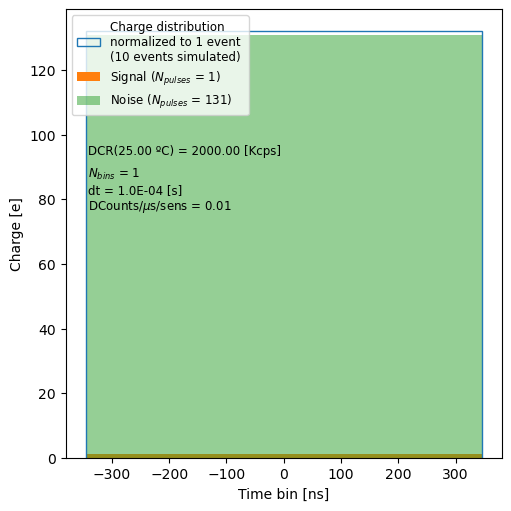

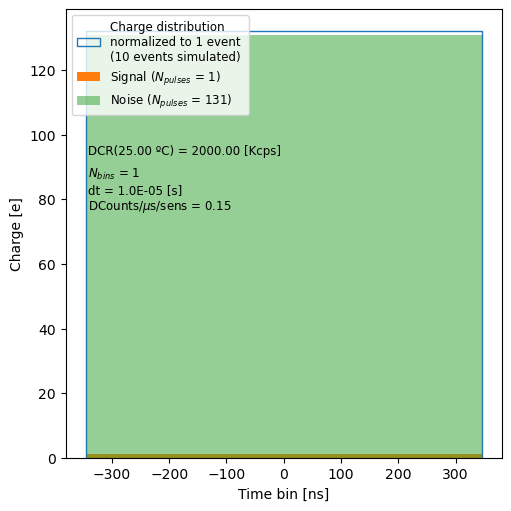

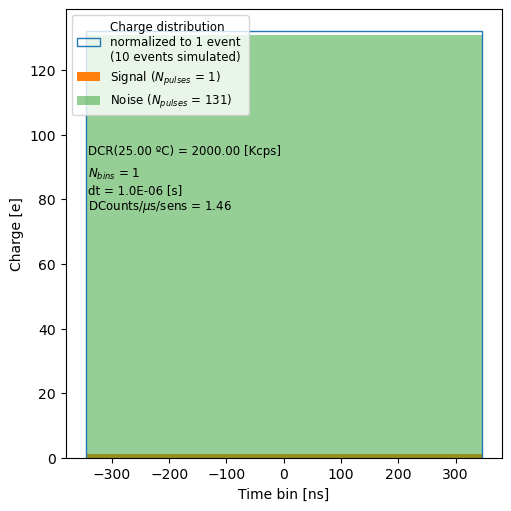

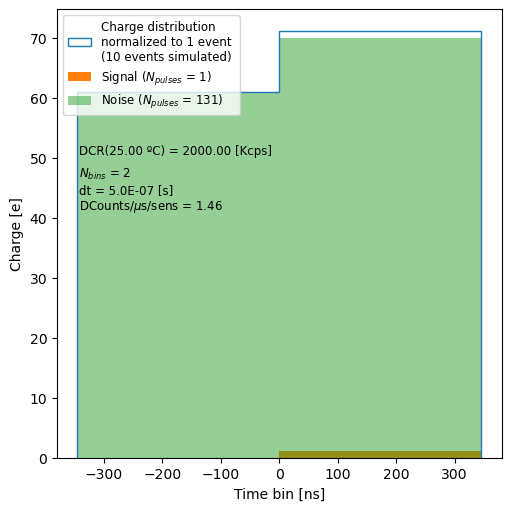

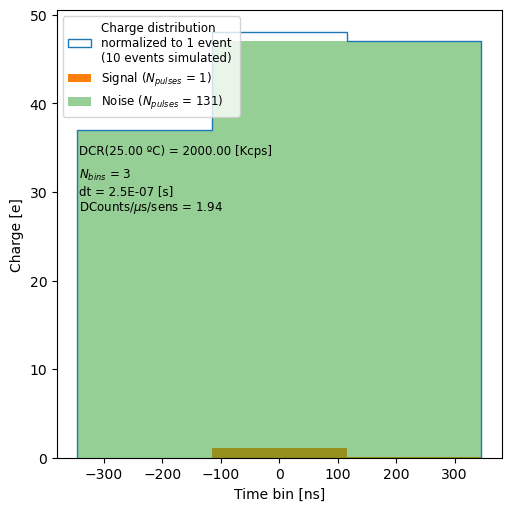

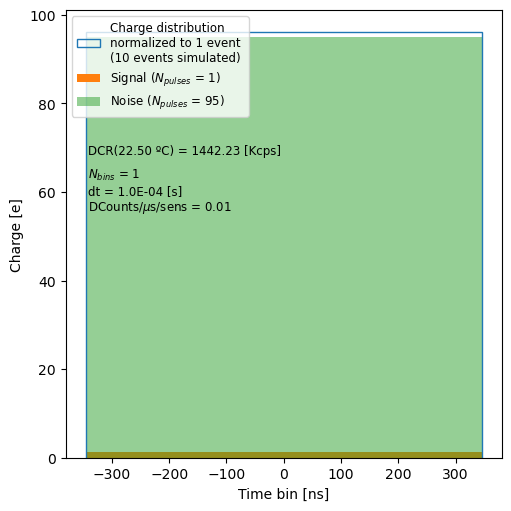

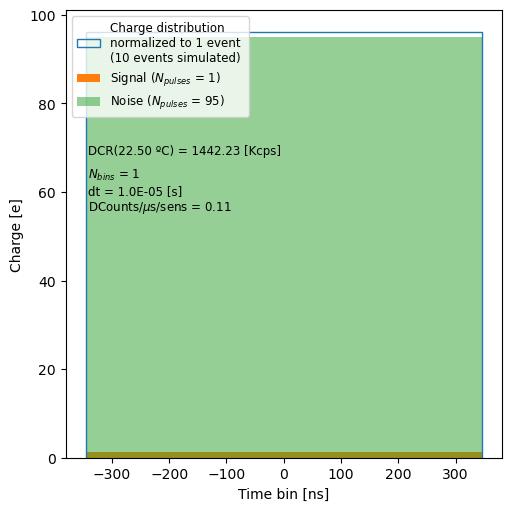

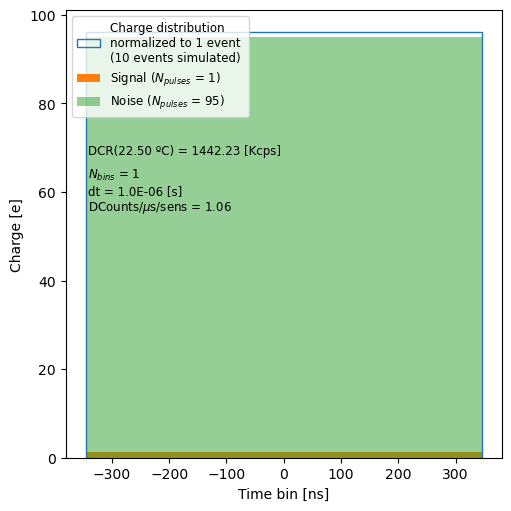

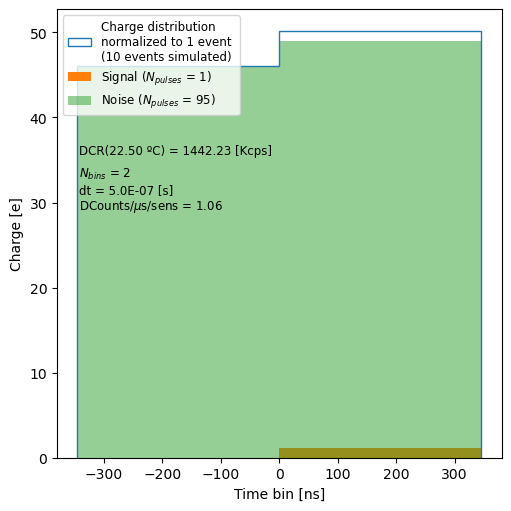

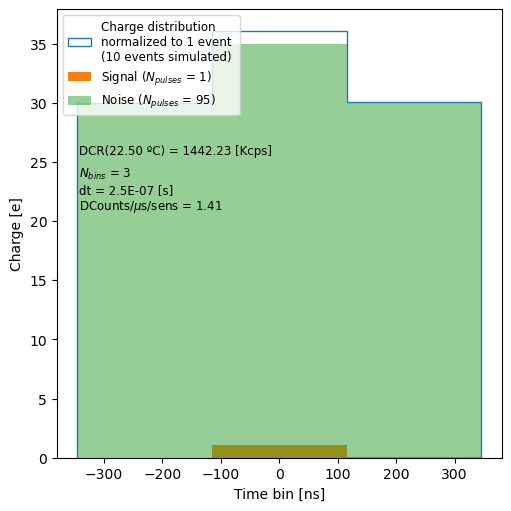

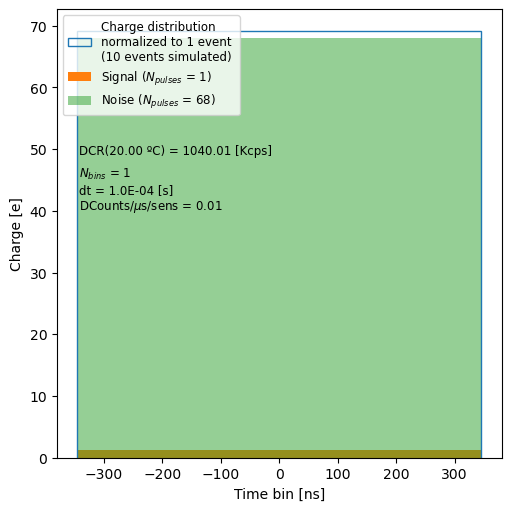

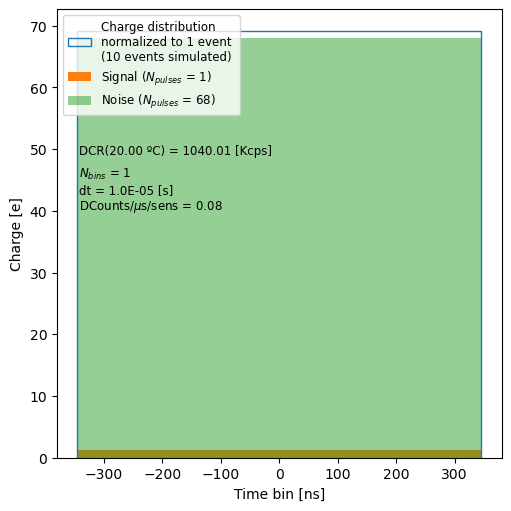

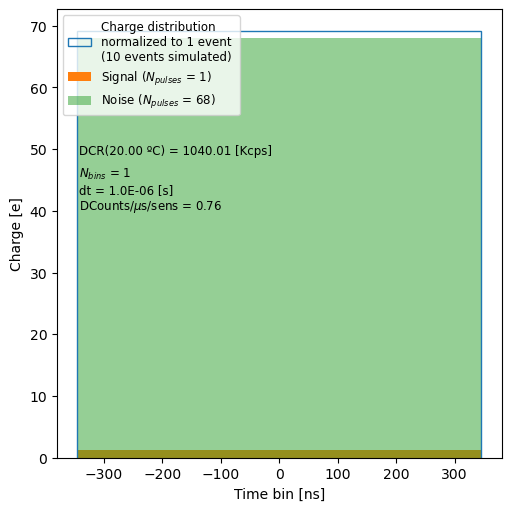

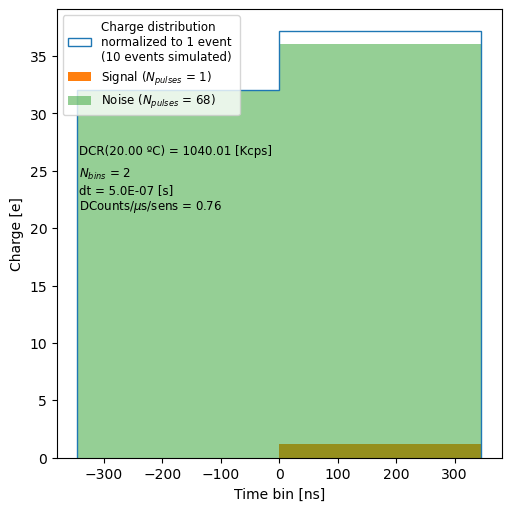

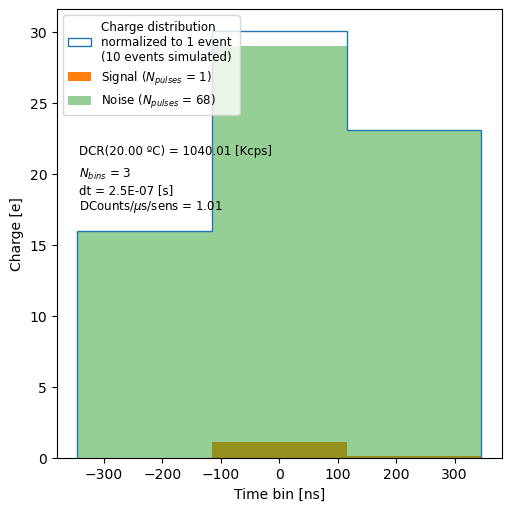

In [54]:
for temp in [25, 22.5, 20]:
    
    DCR = dark_rate(dark25, dT, temp)

    n_1pe, n_2pe = noise(DCR, x_talk, t0, tf, dt, n_sensors)

    print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

    noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
    noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

    t_noise = np.concatenate((noise_1pe, noise_2pe))
    c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

    t_signal = np.asarray(dst.time_bin)
    c_signal = np.asarray(dst.charge)

    tt = np.concatenate((t_signal, t_noise))
    cc = np.concatenate((c_signal/n_events, c_noise))


    font_size = 8.5

    # for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
    for dt in [1e-4, 1e-5, 1e-6, 0.5e-6, 0.25e-6]:

        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

        t_low = -1*(tt.max())
        t_up = tt.max()

    #     dt = (t_up - t_low)*1e-9/n_bins # [s]
        n_bins = int((t_up - t_low)*1e-9/dt) + 1

        # "Data"
        events, bins, bars = ax.hist(tt, n_bins, 
                                     weights = cc,  # only part of it has to be normalized (signal part)
                                     density=False,
                                     range=(t_low, t_up),
                                     label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                     histtype='step')


        # Signal
        s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                           weights = c_signal/n_events,
                                           density=False,
                                           range=(t_low, t_up),
                                           label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                           alpha = 1,
                                           histtype='stepfilled')


        # Noise
        bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                                 weights = c_noise, # noise is already normalized
                                                 density=False,
                                                 range=(t_low, t_up),
                                                 label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                                 alpha = 0.5,
                                                 histtype='stepfilled')


        ax.text(0.05, .7, 
                'DCR(%.2f ºC) = %.2f [Kcps]'%(temp, DCR), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))


        ax.text(0.05, .65, 
                '$N_{bins}$ = %s \ndt = %.1E [s] \nDCounts/$\mu$s/sens = %.2f'%(n_bins, dt, bkg_events.mean()*1e-6/dt/n_sensors), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

        ax.set_ylabel('Charge [e]')
        ax.set_xlabel('Time bin [ns]')
        ax.legend(fontsize = font_size, loc = 'upper left');

        print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                                 s_events.sum(), bkg_events.sum(), 
                                                                 events.sum()))

